In [62]:
import pandas as pd
import numpy as np

from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [63]:
df = pd.read_csv('modelready.csv')

In [64]:
df.columns


Index(['Unnamed: 0', 'win', 'covered', 'covered_over', 'week', 'spread',
       'overunder', 'home', 'days_since', 'win_loss_ratio', 'pfa_ratio',
       'net_wins', 'net_pfa', 'net_pfa_avg', 'home_p', 'covered_by_p',
       'covered_over_by_p', 'covered_p', 'covered_over_p', 'win_by_p', 'win_p',
       'loss_p', 'tie_p', 'bounce_candidate', 'day_of_week_Monday',
       'day_of_week_Saturday', 'day_of_week_Sunday', 'day_of_week_Thursday',
       'day_of_week_Tuesday', 'month_December', 'month_January',
       'month_November', 'month_October', 'month_September', 'bye_1.0',
       'bye_2.0', 'fav', 'fav_p'],
      dtype='object')

In [65]:
#run 
def iterate_vif(df, vif_threshold=5, max_vif=6):
    count = 0
    while max_vif > vif_threshold:
        count += 1
        print("Iteration # "+str(count))
        vif = pd.DataFrame()
        vif["VIFactor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        vif["features"] = df.columns

        if vif['VIFactor'].max() > vif_threshold:
            print('Removing %s with VIF of %f' % (vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], vif['VIFactor'].max()))
            df = df.drop(vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], axis=1)
            max_vif = vif['VIFactor'].max()
        else:
            print('Complete')
            return df, vif.sort_values('VIFactor')

#final_df, final_vif = iterate_vif(X2)

In [66]:
#dataframe for X
X = df[['week', 'spread',
       'overunder', 'home', 'days_since', 'win_loss_ratio', 'pfa_ratio',
       'net_wins', 'net_pfa', 'net_pfa_avg', 'home_p', 'covered_by_p',
       'covered_over_by_p', 'covered_p', 'covered_over_p', 'win_by_p', 'win_p',
       'loss_p', 'tie_p', 'bounce_candidate', 'day_of_week_Monday',
       'day_of_week_Saturday', 'day_of_week_Sunday', 'day_of_week_Thursday',
       'day_of_week_Tuesday', 'month_December', 'month_January',
       'month_November', 'month_October', 'month_September', 'bye_1.0',
       'bye_2.0', 'fav', 'fav_p']]

In [67]:
#Y for forecasting win - this is an easy forecast and will be performed as a check
# - should always be easier to predict that covering the spread
Y = df[['win']]
#Y for forecasting covering the spread
Y2 = df[['covered']]

In [68]:
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
X2_train, X2_test, y2_train, y2_test = train_test_split(X, Y2, test_size=test_size, random_state=seed)

In [69]:
final_df, final_vif = iterate_vif(X_train)
final_df2, final_vif2 = iterate_vif(X2_train)

Iteration # 1


divide by zero encountered in double_scalars


Removing win_p with VIF of inf
Iteration # 2


divide by zero encountered in double_scalars


Removing month_December with VIF of inf
Iteration # 3
Removing bye_1.0 with VIF of 1312.566650
Iteration # 4
Removing day_of_week_Sunday with VIF of 254.935263
Iteration # 5
Removing days_since with VIF of 88.927893
Iteration # 6
Removing overunder with VIF of 55.921331
Iteration # 7
Removing week with VIF of 13.320328
Iteration # 8
Removing pfa_ratio with VIF of 9.847502
Iteration # 9
Removing loss_p with VIF of 8.279054
Iteration # 10
Removing net_pfa with VIF of 7.934543
Iteration # 11
Removing fav_p with VIF of 5.328254
Iteration # 12
Complete
Iteration # 1


divide by zero encountered in double_scalars


Removing win_p with VIF of inf
Iteration # 2


divide by zero encountered in double_scalars


Removing month_December with VIF of inf
Iteration # 3
Removing bye_1.0 with VIF of 1312.566650
Iteration # 4
Removing day_of_week_Sunday with VIF of 254.935263
Iteration # 5
Removing days_since with VIF of 88.927893
Iteration # 6
Removing overunder with VIF of 55.921331
Iteration # 7
Removing week with VIF of 13.320328
Iteration # 8
Removing pfa_ratio with VIF of 9.847502
Iteration # 9
Removing loss_p with VIF of 8.279054
Iteration # 10
Removing net_pfa with VIF of 7.934543
Iteration # 11
Removing fav_p with VIF of 5.328254
Iteration # 12
Complete


In [70]:
X_train = final_df
X2_train = final_df2
X_test=X_test[X_train.columns]
X2_test=X2_test[X2_train.columns]

In [71]:
#Regression

In [72]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression

def run_regression_accuracy(X_train, y_train, X_test, y_test):
  logreg = LogisticRegression(max_iter=10000)
  logreg.fit(X_train, y_train)
  y_pred = logreg.predict(X_test)
  print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
  cm = confusion_matrix(y_test, y_pred)
  print('\nConfusion matrix: \n',cm)

  print('\nClassification report: \n',classification_report(y_test, y_pred))

  logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
  fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])

  plt.figure()
  plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.savefig('Log_ROC')
  plt.show()
  
  return logreg

Accuracy of logistic regression classifier on test set: 0.71

Confusion matrix: 
 [[2143  839]
 [ 875 2062]]

Classification report: 
               precision    recall  f1-score   support

           0       0.71      0.72      0.71      2982
           1       0.71      0.70      0.71      2937

    accuracy                           0.71      5919
   macro avg       0.71      0.71      0.71      5919
weighted avg       0.71      0.71      0.71      5919



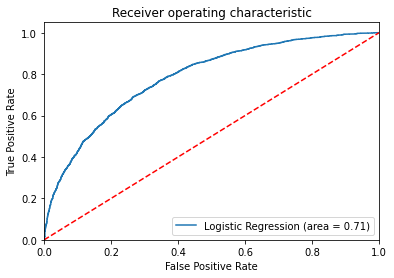

In [73]:
logreg = run_regression_accuracy(X_train, y_train.values.ravel(), X_test, y_test)

Accuracy of logistic regression classifier on test set: 0.54

Confusion matrix: 
 [[2662  475]
 [2266  516]]

Classification report: 
               precision    recall  f1-score   support

           0       0.54      0.85      0.66      3137
           1       0.52      0.19      0.27      2782

    accuracy                           0.54      5919
   macro avg       0.53      0.52      0.47      5919
weighted avg       0.53      0.54      0.48      5919



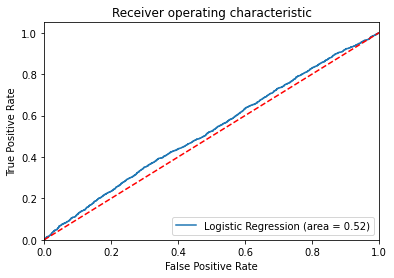

In [74]:
logreg2 = run_regression_accuracy(X2_train, y2_train.values.ravel(), X2_test, y2_test)

In [75]:
#Random Forest

In [76]:
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train.values.ravel())

y_pred=clf.predict(X_test)

from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))



Accuracy: 0.7198851157290083


In [77]:
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf2=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf2.fit(X2_train,y2_train.values.ravel())

y_pred=clf2.predict(X2_test)

from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y2_test, y2_pred))

Accuracy: 0.615644534549755


In [78]:
#Random Forest - Grid Search

In [17]:
rfc=RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X2_train, y2_train.values.ravel())



GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [20, 50, 100]})

In [18]:
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 100}

In [19]:
rfc1=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 100, max_depth=8, criterion='gini')

In [44]:
rfc1.fit(X2_train, y2_train.values.ravel())
pred=rfc1.predict(X2_test)
print("Accuracy for Random Forest on CV data: ",accuracy_score(y2_test,pred))

Accuracy for Random Forest on CV data:  0.6114208481162359


In [45]:
print ('ROC AUC Score',roc_auc_score(y2_test,pred))

ROC AUC Score 0.5999299426363799


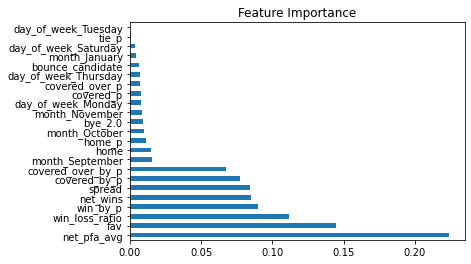

In [21]:
feat_importances = pd.Series(rfc1.feature_importances_, index=X2_train.columns)
feat_importances.nlargest(100).plot(kind='barh')
plt.title("Feature Importance")
plt.show()

In [26]:
#XGB Classifier

In [36]:
# fit model to training data
model = XGBClassifier()
model.fit(X_train, y_train.values.ravel())


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[21:16:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [37]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [38]:

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 71.46%


In [39]:
# rerun for Y2
model.fit(X2_train, y2_train.values.ravel())
# make predictions for test data
y2_pred = model.predict(X2_test)
predictions = [round(value) for value in y2_pred]
# evaluate predictions
accuracy = accuracy_score(y2_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[21:17:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 61.56%


In [40]:
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='neg_mean_squared_error',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(X_test_data)
    else:
      pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred

In [41]:
#model = XGBClassifier()
param_grid = {'learning_rate': [0.01,0.001], 
              'max_depth': [6,7,8,9],
              'seed': [5,6,7,8]}

model, pred = algorithm_pipeline(X2_train, X2_test, y2_train.values.ravel(), y2_test, model, param_grid, cv=5)

# Root Mean Squared Error
print(np.sqrt(-model.best_score_))
print(model.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  1.7min finished
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[21:19:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.6180123320884462
{'learning_rate': 0.01, 'max_depth': 8, 'seed': 5}


In [56]:
xgb1=XGBClassifier(learning_rate = 0.01, max_depth = 8, seed = 5)
xgb1.fit(X2_train, y2_train.values.ravel())

[21:34:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=5,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=5,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [57]:
pred = xgb1.predict(X2_test)

In [58]:
print("Accuracy for XGB Classifier on CV data: ",accuracy_score(y2_test,pred))

Accuracy for XGB Classifier on CV data:  0.6104071633721913


In [59]:
print ('ROC AUC Score',roc_auc_score(y2_test,pred))

ROC AUC Score 0.6005600464024042


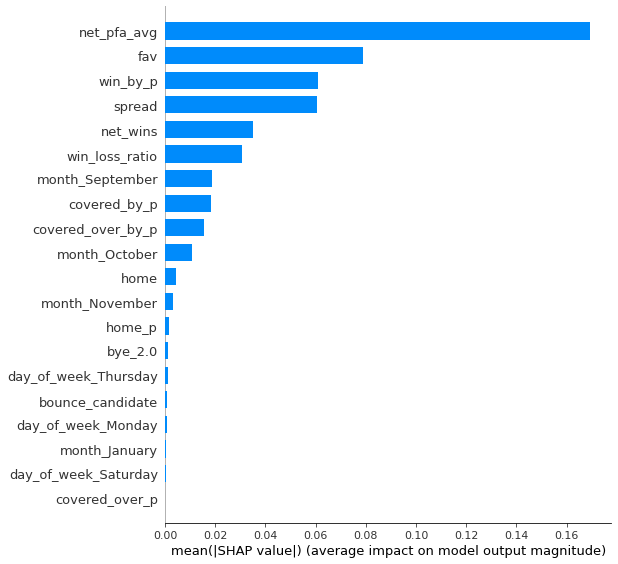

In [61]:
import shap

shap_values = shap.TreeExplainer(xgb1).shap_values(X2_train)
shap.summary_plot(shap_values, X2_train, plot_type="bar")

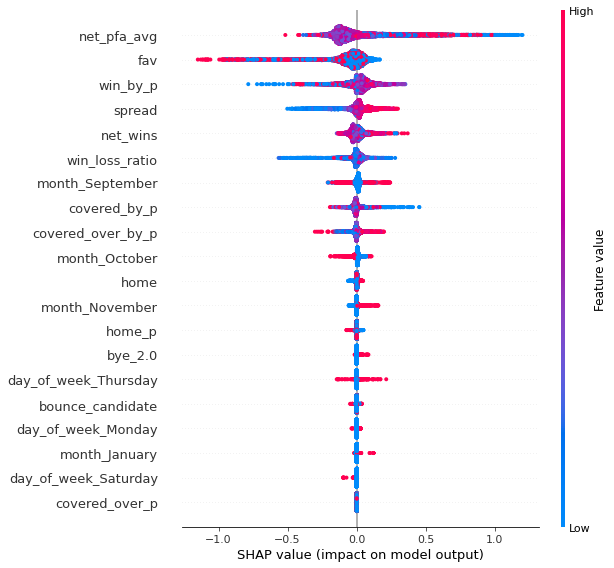

In [79]:
shap.summary_plot(shap_values, X_train)